# Hard Coded XGBoost (Approximate Algorithm)

In [1]:
# Steps:
#     1. Compute residuals
#     For each feature:
#         2. Sort the feature vector asc (let's say the new list's name is sx)
#         3. Devide sx into (1/epsilon) blocks (epsilon is specified by the user)
#         4. Assign sx values to each block (The number of points of each block are equal (we use percentile to split sx))
#         5. For each block find the best split point (using the gain)
#         6. Find the largest gain of all all blocks
#         => That's the optimal split point for the feature
#     7. Select the best feature and the best split point

In [2]:
# There are two methods to use this algorithm
# 1. Local variant: After each split and at each new node set a new epsilon to garentee that the bins in each node stays the same.
# For this methode it's better to make epsilon large (to reduce computation)
# 2. Global variant : We set epsilon only at the beginning (it will get smaller after each split => it should be small).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import KBinsDiscretizer

In [4]:
def XGBoostApproxRegression(X, y, learning_rate, num_iters, lambda_, n_bins=10):
    '''
    Approximate XGBoost function for regression tasks using histogram-based split finding.
    
    Parameters:
    X               Features matrix
    y               Target (continuous values)
    learning_rate   Model learning rate
    num_iters       Number of boosting iterations
    lambda_         Regularization parameter
    n_bins          Number of bins for histogram-based approximation
    
    Returns:
    final_preds     Final predictions after boosting
    prediction_steps List of predictions at each iteration
    '''
    
    # Initialize predictions with the mean of the target
    F_x = np.mean(y) * np.ones_like(y)
    prediction_steps = [F_x.copy()]

    for iter in range(num_iters):
        # Calculate gradients and hessians
        gradients = F_x - y
        hessians = np.ones_like(gradients)

        # Initialize update for each feature
        h_x = np.zeros_like(F_x)
        
        for feature_index in range(X.shape[1]):
            # Histogram-based binning for approximate split finding
            feature_values = X[:, feature_index]
            min_val, max_val = np.min(feature_values), np.max(feature_values)
            bin_edges = np.linspace(min_val, max_val, n_bins + 1)
            
            # Accumulate gradients and hessians in bins
            bin_gradients = np.zeros(n_bins)
            bin_hessians = np.zeros(n_bins)
            
            for grad, hess, value in zip(gradients, hessians, feature_values):
                bin_idx = np.digitize(value, bin_edges) - 1
                bin_idx = min(bin_idx, n_bins - 1)  # Ensure bin_idx is within bounds
                bin_gradients[bin_idx] += grad
                bin_hessians[bin_idx] += hess
            
            # Calculate the best split based on approximate gain
            best_gain = -float('inf')
            best_split = None
            total_grad = np.sum(bin_gradients)
            total_hess = np.sum(bin_hessians)

            for bin_idx in range(1, n_bins):
                left_grad = np.sum(bin_gradients[:bin_idx])
                left_hess = np.sum(bin_hessians[:bin_idx])
                right_grad = total_grad - left_grad
                right_hess = total_hess - left_hess

                # Regularized gain for this split
                gain = 0.5 * (left_grad ** 2 / (left_hess + lambda_) + 
                              right_grad ** 2 / (right_hess + lambda_) - 
                              total_grad ** 2 / (total_hess + lambda_))
                
                if gain > best_gain:
                    best_gain = gain
                    best_split = bin_edges[bin_idx]

            # Apply the best split update to the predictions
            if best_split is not None:
                left_mask = feature_values < best_split
                right_mask = ~left_mask
                h_x[left_mask] += -gradients[left_mask] / (hessians[left_mask] + lambda_)
                h_x[right_mask] += -gradients[right_mask] / (hessians[right_mask] + lambda_)

        # Update cumulative prediction with learning rate
        F_x += learning_rate * h_x
        prediction_steps.append(F_x.copy())

    final_preds = F_x
    return final_preds, prediction_steps


## Demo

In [5]:
# Example dataset: simple linear relationship with noise
np.random.seed(0)
X = np.random.rand(100, 1) * 10  # 100 samples, 1 feature
y = 3 * X.squeeze() + 5 + np.random.randn(100) * 2  # y = 3*X + 5 + noise

# Define parameters
learning_rate = 0.1
num_iters = 10
lambda_ = 1.0
n_bins = 10

final_preds, prediction_steps = XGBoostApproxRegression(X, y, learning_rate, num_iters, lambda_, n_bins)

for i in range(10):
    print(f"Actual value: {y[i]:.2f}     Predicted value: {final_preds[i]:.2f}")

Actual value: 19.13     Predicted value: 19.39
Actual value: 28.26     Predicted value: 23.05
Actual value: 24.01     Predicted value: 21.35
Actual value: 18.27     Predicted value: 19.05
Actual value: 20.69     Predicted value: 20.02
Actual value: 28.17     Predicted value: 23.02
Actual value: 20.49     Predicted value: 19.94
Actual value: 31.39     Predicted value: 24.31
Actual value: 31.77     Predicted value: 24.46
Actual value: 18.61     Predicted value: 19.18


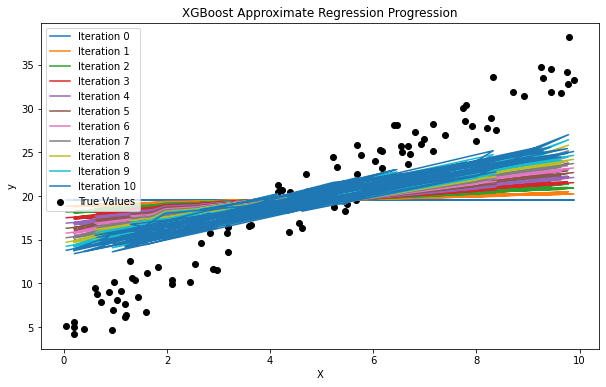

In [6]:
# Plot the progress of predictions
plt.figure(figsize=(10, 6))
for i, preds in enumerate(prediction_steps):
    plt.plot(X, preds, label=f'Iteration {i}')
plt.scatter(X, y, color='black', label='True Values')
plt.xlabel('X')
plt.ylabel('y')
plt.title('XGBoost Approximate Regression Progression')
plt.legend()
plt.show()

# Sklearn XGBoost (Approximate Algorithm)

In [7]:
# sklearn doesn't have a specified method for the approximate algorithm so we use KBinsDiscretizer to make bins from X
# and we simply apply GradientBoostingRegressor on the X_binned

In [8]:
def sklearn_approx_xgboost_regression(X, y, learning_rate=0.1, n_estimators=10, max_depth=3, n_bins=10):
    '''
    Approximate XGBoost-style regression using histogram-based binning and GradientBoostingRegressor in sklearn.
    
    Parameters:
    X               Features matrix
    y               Target values
    learning_rate   Learning rate for the boosting model
    n_estimators    Number of boosting iterations
    max_depth       Maximum depth of the individual regression estimators
    n_bins          Number of bins for histogram-based binning of the features
    
    Returns:
    model           Trained GradientBoostingRegressor model
    predictions     Final predictions on the training data
    '''
    # Apply quantile-based binning to each feature
    binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    X_binned = binner.fit_transform(X)

    # Initialize Gradient Boosting Regressor with binned data
    model = GradientBoostingRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        criterion='squared_error'
    )
    model.fit(X_binned, y)
    
    # Predict with the model on binned data
    predictions = model.predict(X_binned)
    return model, predictions